In [137]:
import numpy as np
import os, sys

from osgeo import gdal
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Model
from keras.optimizers import Adam

## Keras related modules
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.facecolor':'white',
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [70]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [71]:
raster_data_path = "images/tiles/tile_1000_4000.tif"
output_fname = ".classification.tif"
shapefile_path = "./shape_files/splits/"
# validation_data_path = "data/train/"

In [72]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []

In [73]:
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [74]:
print(rows, cols, n_bands)

1000 1000 11


In [75]:
files = [f for f in os.listdir(shapefile_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(shapefile_path, f)
              for f in files if f.endswith('.shp')]

In [76]:
data_source = gdal.OpenEx(shapefile_path, gdal.OF_VECTOR)
layer = data_source.GetLayer(0)

In [77]:
labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [78]:
is_train = np.nonzero(labeled_pixels)

In [79]:
print(np.shape(labeled_pixels), np.shape(bands_data))

(1000, 1000) (1000, 1000, 11)


In [80]:
xtrain = np.delete(bands_data, 10, 2)

In [81]:
xtrain = np.delete(xtrain, 9, 2)

In [82]:
n_samples = rows*cols
flat_pixels = xtrain.reshape((n_samples, 9))

In [83]:
ytrain = labeled_pixels.reshape((n_samples, 1))

In [84]:
print(np.shape(xtrain))

(1000, 1000, 9)


### Class distribution

In [85]:
from scipy.stats import itemfreq
print(itemfreq(ytrain).astype(int))

[[     0 690188]
 [     1 274063]
 [     2  35749]]


In [86]:
ytrain[ytrain == 5 ] = 0

In [156]:
label_count = itemfreq(ytrain).astype(int)[:,1]
class_name = ['Low land', 'Elevated area', 'Water bodies']

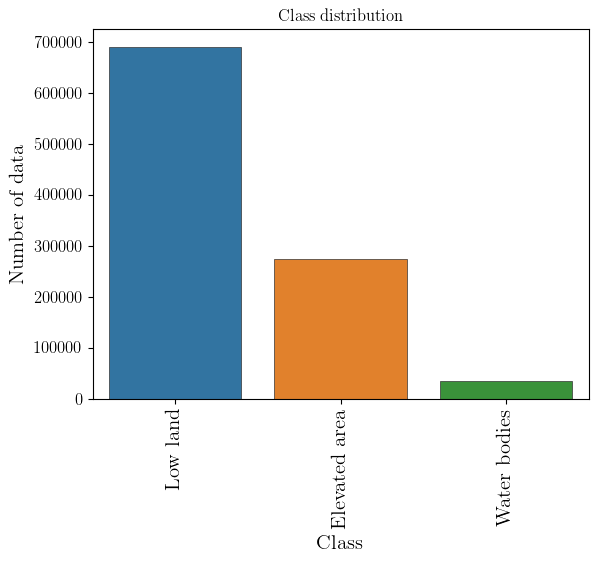

In [157]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x = class_name, y = label_count, linewidth = 0.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15, rotation = 'vertical')
plt.title('Class distribution')
plt.show()

### Preprocessing

In [89]:
mms = StandardScaler()
xtrain_scaled = mms.fit_transform(flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


 ## Random forest classification

In [90]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain_scaled, ytrain)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
result = classifier.predict(xtrain_scaled)

In [92]:
classification = result.reshape((rows, cols))

In [96]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

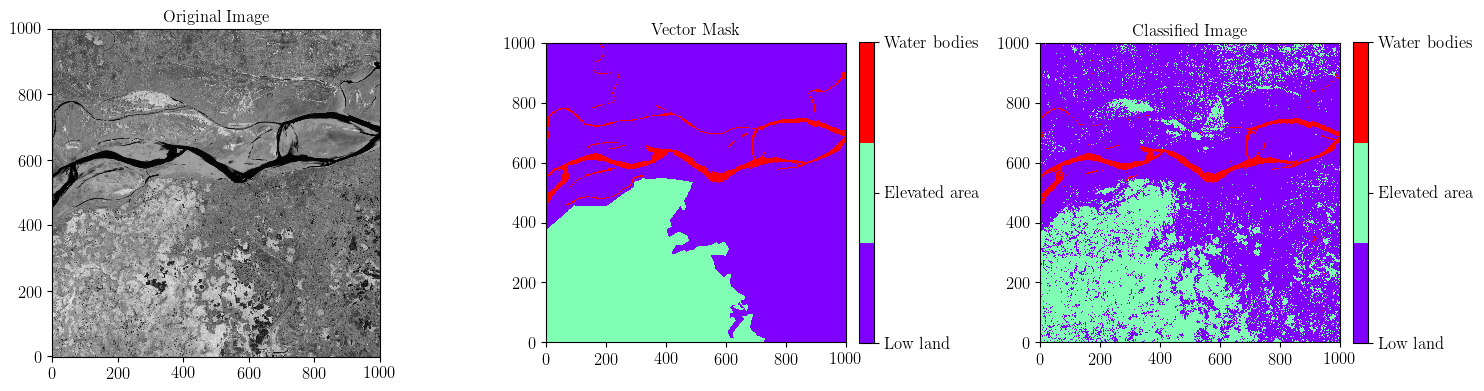

In [158]:
f = plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(bands_data[:, :, 6])
plt.title('Original Image')

plt.subplot(1, 3, 2)
im = plt.imshow(labeled_pixels.astype(np.float64), cmap = discrete_cmap(3, 'rainbow'))
plt.title('Vector Mask')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(class_name)

plt.subplot(1, 3, 3)
im = plt.imshow(classification, cmap = discrete_cmap(3, 'rainbow'))
plt.title('Classified Image')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(class_name)

plt.tight_layout()
plt.show()

###  Testing-1 : tiles: 5000/5000

In [148]:
test_data_path = "images/tiles/tile_1000_3000.tif"
test_raster = gdal.Open(test_data_path, gdal.GA_ReadOnly)
geo_transform = test_raster.GetGeoTransform()
proj = test_raster.GetProjectionRef()
test_bands_data = []

In [149]:
for b in range(1, test_raster.RasterCount+1):
    band = test_raster.GetRasterBand(b)
    test_bands_data.append(band.ReadAsArray())

test_bands_data = np.dstack(test_bands_data)
test_rows, test_cols, test_n_bands = test_bands_data.shape

In [150]:
np.shape(test_bands_data)

(1000, 1000, 11)

In [151]:
xtest = np.delete(test_bands_data, 10, 2)
xtest = np.delete(xtest, 9, 2)

In [152]:
np.shape(xtest)

(1000, 1000, 9)

In [153]:
test_flat_pixels = xtest.reshape((n_samples, 9))
test_mms = StandardScaler()
xtest_scaled = test_mms.fit_transform(test_flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [154]:
test_result = classifier.predict(xtest_scaled)
test_classification = test_result.reshape((rows, cols))

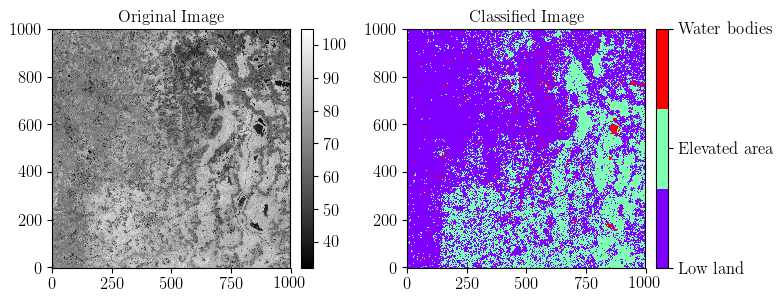

In [159]:
f = plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
im = plt.imshow(test_bands_data[:, :, 6])
plt.title('Original Image')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
im = plt.imshow(test_classification, cmap=discrete_cmap(3, 'rainbow'))
plt.title('Classified Image')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(class_name)
plt.tight_layout()
plt.show()

## Deep neural Network

## Create model

In [114]:
len(ytrain)

1000000

In [116]:
weights = len(ytrain) / (3 * np.unique(ytrain))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [117]:
weights

array([            inf, 333333.33333333, 166666.66666667])

In [112]:
aa = class_weight.compute_class_weight('balanced', 
                                       np.unique(ytrain.astype(int)), 
                                       ytrain.astype(int))

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
CLASS_WEIGHT = {0 : aa[0] , 1: aa[1], 2: aa[2]}

#### 1. Hyperparameters

In [121]:
HIDDEN_LAYER_SIZE = 12
L2_REGULARIZER = 5
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 15
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.30
# CLASS_WEIGHT = CLASS_WEIGHT

#### 2. Model setup

In [122]:
model = Sequential()
model.add(Dense(16, activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                input_shape = (9,),
                name = 'layer_1'))

model.add(Dense(8, activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                name = 'layer_2'))

model.add(Dense(4, activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                name = 'layer_3'))


adm_optz = optimizers.Adam(lr = LEARNING_RATE)
model.add(Dense(4, activation = "softmax", name = 'Output_layer'))

model.compile(optimizer = adm_optz, loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#### 3. Train model

In [123]:
ytrain_on_hot = to_categorical(ytrain, num_classes=4)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)

history = model.fit(xtrain_scaled, ytrain_on_hot, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
#                     class_weight = CLASS_WEIGHT,
#                     callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 1)

Train on 700000 samples, validate on 300000 samples
Epoch 1/15
700000/700000 [==============================] - 90s - loss: 0.6772 - acc: 0.7505 - val_loss: 0.4841 - val_acc: 0.8004
Epoch 2/15
700000/700000 [==============================] - 88s - loss: 0.3750 - acc: 0.8414 - val_loss: 0.4191 - val_acc: 0.8330
Epoch 3/15
700000/700000 [==============================] - 95s - loss: 0.3597 - acc: 0.8491 - val_loss: 0.3488 - val_acc: 0.8652
Epoch 4/15
700000/700000 [==============================] - 89s - loss: 0.3520 - acc: 0.8524 - val_loss: 0.3654 - val_acc: 0.8592
Epoch 5/15
700000/700000 [==============================] - 91s - loss: 0.3474 - acc: 0.8539 - val_loss: 0.3694 - val_acc: 0.8585
Epoch 6/15
700000/700000 [==============================] - 94s - loss: 0.3440 - acc: 0.8552 - val_loss: 0.3867 - val_acc: 0.8507
Epoch 7/15
700000/700000 [==============================] - 98s - loss: 0.3414 - acc: 0.8563 - val_loss: 0.3585 - val_acc: 0.8672
Epoch 8/15
700000/700000 [============

#### 4. Training History

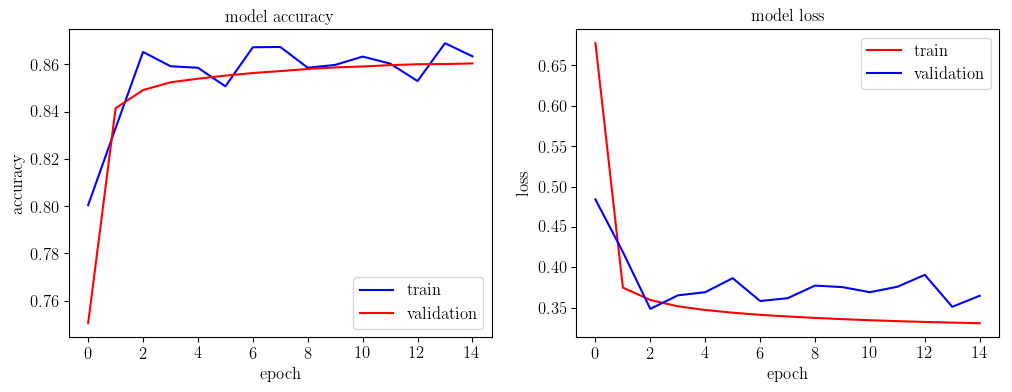

In [124]:
plt.figure(figsize= (12, 4))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_acc'], 'b-')
plt.plot(history.history['acc'], 'r-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### 5. Prediction

In [167]:
ypred = model.predict(xtest_scaled)

In [168]:
nnypred = np.argmax(ypred, axis = 1)

In [169]:
classification = nnypred.reshape((rows, cols))

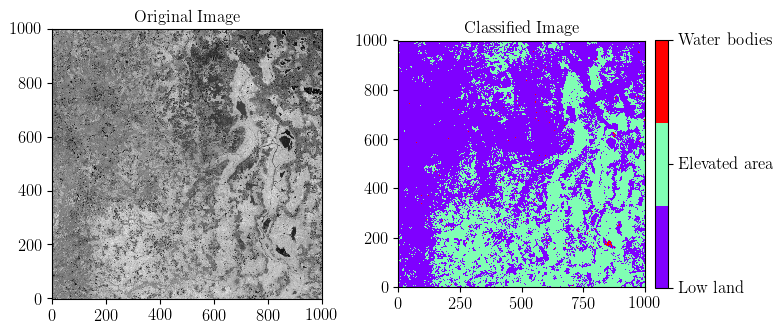

In [171]:
f = plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
im = plt.imshow(test_bands_data[:, :, 6])
plt.title('Original Image')
# plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
im = plt.imshow(classification, cmap=discrete_cmap(3, 'rainbow'))
plt.title('Classified Image')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(class_name)
plt.tight_layout()
plt.show()

### Training classification report

In [138]:
print('Accuracy of the model: {}\n'.format(accuracy_score(ytrain, nnypred)))
print('Classification report: \n{}\n'.format(classification_report(ytrain, nnypred)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytrain, nnypred)))

Accuracy of the model: 0.861356

Classification report: 
             precision    recall  f1-score   support

        0.0       0.91      0.89      0.90    690188
        1.0       0.75      0.81      0.78    274063
        2.0       0.89      0.77      0.83     35749

avg / total       0.86      0.86      0.86   1000000


Confusion matrix: 
[[613078  73803   3307]
 [ 53397 220662      4]
 [  8079     54  27616]]



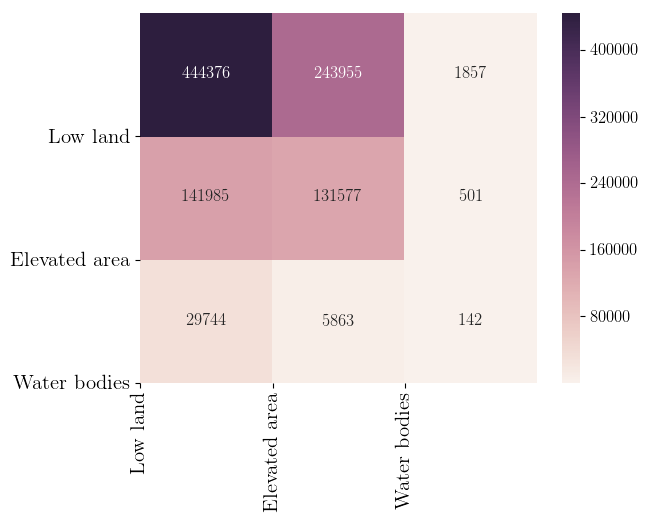

In [166]:
sns.heatmap(confusion_matrix(ytrain, nnypred), annot=True, fmt="d")
plt.xticks(index, class_name, fontsize=15, rotation = 'vertical')
plt.yticks(index, class_name[::-1], fontsize=15, rotation = 'horizontal')
plt.show()